# RSTDP domain adaptation of pre-trained agents for modified CartPole environments

In [1]:
import os, sys
from datetime import date

import numpy as np
import torch
import torch.optim as optim
import random
import gym
import matplotlib.pyplot as plt
from copy import deepcopy

import torch.nn.functional as F

# script_dir = os.path.dirname( __file__ )
# mymodule_dir = os.path.join( script_dir, '..', 'alpha', 'beta' )
# sys.path.append( script_dir )


from utils import evaluate_policy, rstdp_train_cartpole

import site
site.addsitedir('../src/')

from dsnn import RSTDPNet
from model import DSNN

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print(device)

cpu


In [3]:
# Environment specific parameters
env_name = 'CartPole-v0'
max_reward = 200
max_steps = 200

n_evaluations = 100
rstdp_episodes = 250

In [4]:
# Create environments
original_env = gym.make(env_name)

modified_env = gym.make(env_name)
modified_env.unwrapped.length *= 1.5

c:\Users\maxim\anaconda3\envs\drl_cpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
# SNN Hyperparameters
simulation_time = 8
alpha = 0.8
beta = 0.8
threshold = 0.5
weight_scale = 1
architecture = [8, 64, 64, 2]

In [6]:
# RSTDP Hyperparameters
tau = 5
tau_e = 10
C = 0.01
# A+/- are calculated from the pre-trained network weights

In [7]:
evaluation_seeds = np.load('../seeds/evaluation_seeds.npy')
rstdp_seeds = np.load('../seeds/rstdp_training_seeds.npy')

In [8]:
# Load pre-trained model weights
weights_0 = torch.load('pretrained_models/cartpole/checkpoint_DSQN_0.pt', map_location=torch.device(device))
weights_1 = torch.load('pretrained_models/cartpole/checkpoint_DSQN_1.pt', map_location=torch.device(device))
weights_2 = torch.load('pretrained_models/cartpole/checkpoint_DSQN_2.pt', map_location=torch.device(device))
weights = [weights_0, weights_1, weights_2]

In [9]:
# Helper for printing
eraser = '\b \b'

### Evaluate pre-trained models on original environment

In [10]:
original_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w, 
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, original_env, n_evaluations, evaluation_seeds)
    original_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

Run 00 ...

KeyboardInterrupt: 

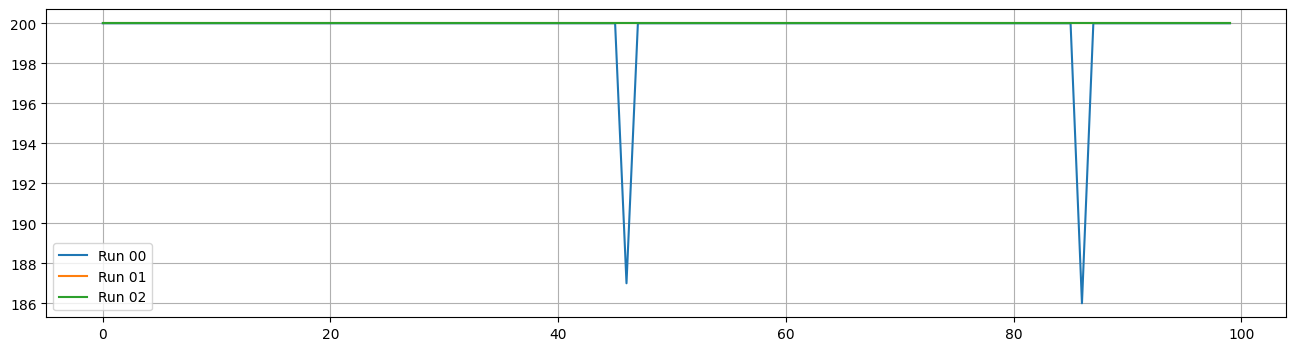

In [12]:
plt.figure(figsize=(16, 4))

for i, oer in enumerate(original_eval_rewards):
    plt.plot(oer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()

### Evaluate pre-trained models on modified environment

In [11]:
modified_env_eval_rewards = []

for i, w in enumerate(weights):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    modified_env_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

Run 00 -> Avg reward:  186.41
Run 01 -> Avg reward:  200.00
Run 02 -> Avg reward:  132.76


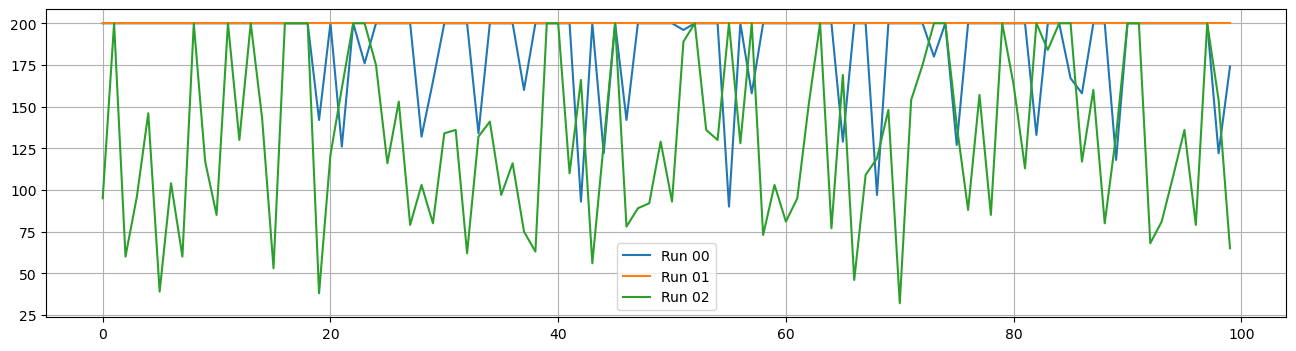

In [12]:
plt.figure(figsize=(16, 4))

for i, meer in enumerate(modified_env_eval_rewards):
    plt.plot(meer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()

### RSTDP Adaptation

In [13]:
rstdp_adaptation_rewards = []
adapted_weights_collection = []

for i, w in enumerate(weights):
    w_plus = deepcopy(w[0][1])
    w_minus = deepcopy(w[0][1])
    w_plus[w_plus < 0] = 0
    w_minus[w_minus > 0] = 0
    A_plus = torch.mean(w_plus)
    A_minus = torch.abs(torch.mean(w_minus))
    
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w, 
                                  tau, tau_e, A_plus, A_minus, C, 
                                  device=device, dtype=dtype)
    
    adapted_weights, rewards = rstdp_train_cartpole(policy_net, modified_env, max_reward, rstdp_episodes, 
                                                 n_evaluations, max_steps, rstdp_seeds, evaluation_seeds)
    
    rstdp_adaptation_rewards.append(rewards)
    adapted_weights_collection.append(adapted_weights)
    
adapted_weights_collection = [(list(aw.values()), []) for aw in adapted_weights_collection]

### Temporal Difference Delta Rule Adaptation

In [ ]:
def TDNet :
    ADD value to network

for step in environment:

    observation <- step
    action, value = TDNet(observation)
    reward = environment(action)


In [ ]:
alpha = 
gamma =
lr = 

num_episodes = rstdp_episodes
env = modified_env

hidden_net = DSNN(architecture[:-1], seed=0, alpha, beta, weight_scale, batch_size, threshold,
                      simulation_time, learning_rate, spk_out_sum=True)
weight_seed0 = weights[0]
hidden_net.load_weights(weight_seed0[:-1]) #Only hidden network
actor_weights = weight_seed0[-1]
value_weights = torch.empty((architecture[-2], architecture[-1]), device=device, dtype=torch.float, requires_grad=False)
torch.nn.init.normal_(value_weights, mean=0.0, std=weight_scale/np.sqrt(architecture[-1]))


In [ ]:
env._max_episode_steps = max_steps

best_reward = -np.inf
best_episode = -1
best_weights = None

rewards = []

for i_episode in range(num_episodes):
    env.seed(int(rstdp_seeds[i_episode]))
    
    e_trace = None
    
    state = env.reset()
    total_reward = 0
    for t in range(max_steps):
        inputs = torch.from_numpy(state).float()


        z_spkcount = hidden_net.forward(inputs)

        new_value = torch.multiply(z_spkcount, value_weights)
        action_logits = torch.multiply(z_spkcount, actor_weights)

        # Action definition + application
        action = np.argmax(action_logits)
        action_oh = F.one_hot(action, num_classes=actor_weights.size()[-1])

        state, reward, done, _ = env.step(action)


        # TD Delta Update
        hidden_trace = alpha*hidden_trace + z_spkcount
        action_trace = alpha*action_trace + action_oh

        td_error = reward + gamma*new_value - value
        value_weights += lr*td_error*hidden_trace  ## REMOVE BATCH DIMENSION IF BATCH
        actor_weights += lr*td_error*hidden_trace * action_trace 

        value = new_value

        total_reward += reward
        if done: ### DONE WHEN FULLY FALLING: LEAVE SOME WRONG ANGLE TO TRAIN ON
            break

    rewards.append(total_reward)
    
    eval_rewards = evaluate_policy(policy_net, env, n_evaluations, evaluation_seeds)
    avg_eval_reward = np.mean(eval_rewards)

### Evaluate adapted models on modified environment

In [ ]:
adapted_eval_rewards = []

for i, w in enumerate(adapted_weights_collection):
    print('Run {:02d} ...'.format(i), end='')
    policy_net = RSTDPNet(alpha, beta, threshold, architecture, simulation_time, w,
                                  device=device, dtype=dtype)
    rewards = evaluate_policy(policy_net, modified_env, n_evaluations, evaluation_seeds)
    adapted_eval_rewards.append(rewards)
    print(eraser*3 + '-> Avg reward: {:7.2f}'.format(np.mean(rewards)))

In [ ]:
plt.figure(figsize=(16, 4))

for i, aer in enumerate(adapted_eval_rewards):
    plt.plot(aer, label='Run {:02d}'.format(i))

plt.legend()
plt.grid()
plt.show()